## Load Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import ndcg_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import os
import logging
from fuxictr.utils import load_config, set_logger, print_to_json
from fuxictr.features import FeatureMap
from fuxictr.pytorch.torch_utils import seed_everything
from fuxictr.pytorch.dataloaders import H5DataLoader
from fuxictr.preprocess import FeatureProcessor, build_dataset
import src
import gc
import os

/Users/rafael/miniconda3/envs/recsys/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
books_df = pd.read_csv('data/book/Books.csv')
users_df = pd.read_csv('data/book/Users.csv')
ratings_df = pd.read_csv('data/book/Ratings.csv')

df = pd.merge(users_df, ratings_df, on='User-ID', how='left')
df = pd.merge(df, books_df, on='ISBN', how='left')

df.head()

/Users/rafael/miniconda3/envs/recsys/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,1,"nyc, new york, usa",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"stockton, california, usa",18.0,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,3,"moscow, yukon territory, russia",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"porto, v.n.gaia, portugal",17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,"farnborough, hants, united kingdom",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

1. Remove observations where the user did not read the book

In [3]:
df = df[df['Book-Rating'].notnull()]

2. Check missing values
 - Replace Book-Author and Publisher with `unknown`

In [4]:
df.columns[df.isna().any()].tolist()

['Age',
 'Book-Title',
 'Book-Author',
 'Year-Of-Publication',
 'Publisher',
 'Image-URL-S',
 'Image-URL-M',
 'Image-URL-L']

In [5]:
df['Book-Author'] = df['Book-Author'].fillna('unknown')
df['Publisher'] = df['Publisher'].fillna('unknown')

3. Remove observations with missing information about the book

In [6]:
df = df[df['Book-Title'].notnull()]

4. Replace non integer Years with Nans

In [7]:
df['Year-Of-Publication'] = pd.to_numeric(df['Year-Of-Publication'], errors='coerce')

5. Check Age, Year-Of-Publication and Book-Rating distribution

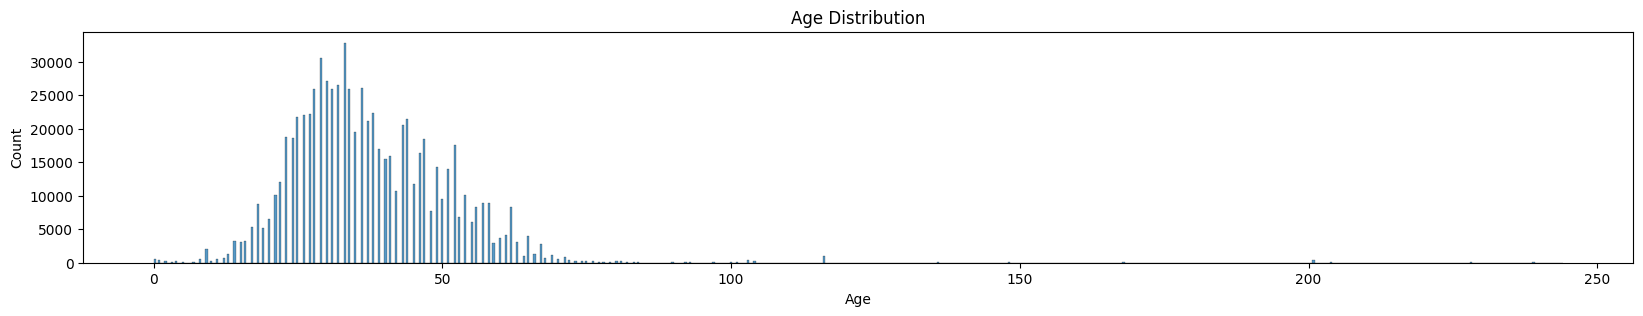

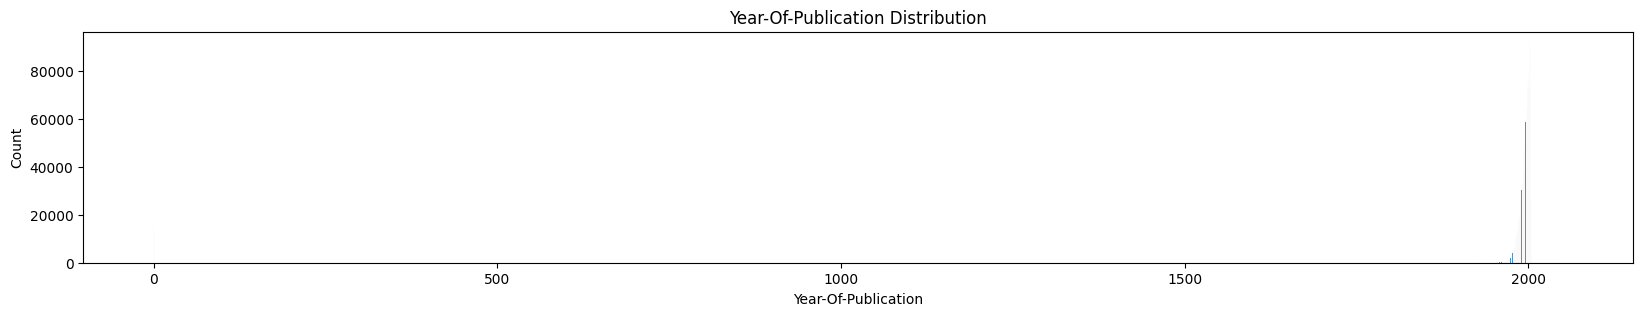

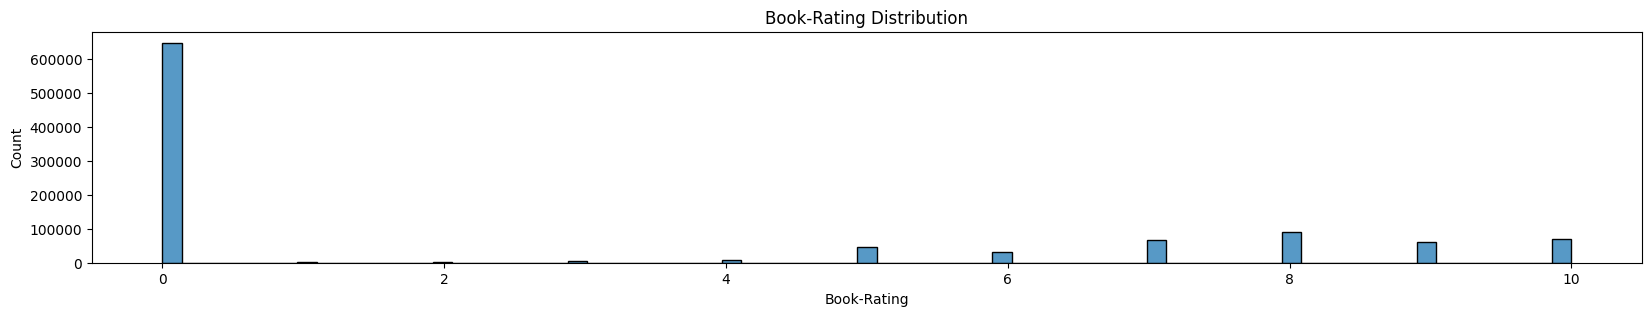

In [8]:
plt.rcParams["figure.figsize"] = (20,3)
sns.histplot(data=df, x='Age')
plt.title('Age Distribution')
plt.show()

sns.histplot(data=df, x='Year-Of-Publication')
plt.title('Year-Of-Publication Distribution')
plt.show()

sns.histplot(data=df, x='Book-Rating')
plt.title('Book-Rating Distribution')
plt.show()


6. Clean up data:
    - Replace Ages with values higher than 100 (which seems an error) with Nans
    - Replace Year-of-Publication <= 0 with median value and setting the maximum possible year to 2021
    - Remove Observations with Rating = 0, since those where books read by the user but they did not rated them
    - Create 3 features (city, state, country) from Location
    - Create binary label, let's assume that ratings above 7 are interesting for the customer and below or equal to 7 are not interesting

In [9]:
df['Age'] = np.where(df['Age'] > 100, None, df['Age'])

df['Year-Of-Publication'] = np.where(df['Year-Of-Publication'] <= 0, np.nanmedian(df['Year-Of-Publication']), df['Year-Of-Publication']).clip(0, 2021).astype(str)

df = df[df['Book-Rating'] > 0]

df['city'] = df['Location'].apply(lambda x: x.split(',')[0].strip()) # too noisy, we will not use
df['state'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
df['country'] = df['Location'].apply(lambda x: x.split(',')[2].strip())

df['label'] = (df['Book-Rating'] > 7)*1

## Modeling

### Split Test-Train Data

In [10]:
# create list with unique users
users = df['User-ID'].unique()
# shuffle list
random.shuffle(users)
# create list of users to train and to test
train_users = users[:int(0.7*len(users))]
val_users = users[int(0.7*len(users)):int(0.8*len(users))]
test_users = users[int(0.8*len(users)):]
# train and test df
train_df = df[df['User-ID'].isin(train_users)]
val_df = df[df['User-ID'].isin(val_users)]
test_df = df[df['User-ID'].isin(test_users)]

### Pre-Process dataset

1. Convert textual feature `Book-Title` into embedding vector
 - Multilingual model to encode `Book-Title` since it is written in different languages
 - Reduce dimensionality of the embeddings with PCA and 80% of variance explained.
 - Extract distinct `Book-Title` first in order to not bias the dimensionality reduction if a book was read by more users than other

In [11]:
# model to create embeddings
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# train, val and test embeddings
training_books = train_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()
val_books = val_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()
test_books = test_df.loc[:, ["ISBN", "Book-Title"]].drop_duplicates()

train_embeddings = model.encode(training_books["Book-Title"].tolist(), normalize_embeddings=True)
val_embeddings = model.encode(val_books["Book-Title"].tolist(), normalize_embeddings=True)
test_embeddings = model.encode(test_books["Book-Title"].tolist(), normalize_embeddings=True)

# reduce dimensionality with PCA
pca = PCA(n_components=0.8, random_state=42)
train_embeddings = pca.fit_transform(train_embeddings)
val_embeddings = pca.fit_transform(val_embeddings)
test_embeddings = pca.transform(test_embeddings)

# join embeddings to dfs
train_embeddings_df = pd.DataFrame(train_embeddings)
train_embeddings_df.columns = [f"Book-Title_{i}" for i in train_embeddings_df.columns]
training_books = pd.merge(training_books.reset_index(drop=True), train_embeddings_df, left_index=True, right_index=True)
train_df = pd.merge(train_df, training_books, on=["ISBN", "Book-Title"])

val_embeddings_df = pd.DataFrame(val_embeddings)
val_embeddings_df.columns = [f"Book-Title_{i}" for i in val_embeddings_df.columns]
val_books = pd.merge(val_books.reset_index(drop=True), val_embeddings_df, left_index=True, right_index=True)
val_df = pd.merge(val_df, val_books, on=["ISBN", "Book-Title"])

test_embeddings_df = pd.DataFrame(test_embeddings)
test_embeddings_df.columns = [f"Book-Title_{i}" for i in test_embeddings_df.columns]
test_books = pd.merge(test_books.reset_index(drop=True), test_embeddings_df, left_index=True, right_index=True)
test_df = pd.merge(test_df, test_books, on=["ISBN", "Book-Title"])

2. Fill missing values of `Age` with mean

In [12]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
val_df['Age'] = val_df['Age'].fillna(train_df['Age'].mean())
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].mean())

#### Save pre-processed datasets

In [13]:
train_df.to_csv('data/book/train.csv', index=False)
val_df.to_csv('data/book/valid.csv', index=False)
test_df.to_csv('data/book/test.csv', index=False)

### Get model and dataset configurations

In [2]:
experiment_id = 'FinalMLP_book'
params = load_config(f"config/{experiment_id}/", experiment_id)
params['gpu'] = -1
set_logger(params)
logging.info("Params: " + print_to_json(params))
seed_everything(seed=params['seed'])

2024-02-09 22:20:40,257 P20618 INFO Params: {
    "batch_size": "4096",
    "data_format": "csv",
    "data_root": "./data/book/",
    "dataset_id": "FinalMLP_book",
    "debug_mode": "False",
    "early_stop_patience": "2",
    "embedding_dim": "10",
    "embedding_regularizer": "0.01",
    "epochs": "10",
    "eval_steps": "None",
    "feature_cols": "[{'active': True, 'dtype': 'float', 'name': ['Age', 'Book-Title_0', 'Book-Title_1', 'Book-Title_2', 'Book-Title_3', 'Book-Title_4', 'Book-Title_5', 'Book-Title_6', 'Book-Title_7', 'Book-Title_8', 'Book-Title_9', 'Book-Title_10', 'Book-Title_11', 'Book-Title_12', 'Book-Title_13', 'Book-Title_14', 'Book-Title_15', 'Book-Title_16', 'Book-Title_17', 'Book-Title_18', 'Book-Title_19', 'Book-Title_20', 'Book-Title_21', 'Book-Title_22', 'Book-Title_23', 'Book-Title_24', 'Book-Title_25', 'Book-Title_26', 'Book-Title_27', 'Book-Title_28', 'Book-Title_29', 'Book-Title_30', 'Book-Title_31', 'Book-Title_32', 'Book-Title_33', 'Book-Title_34', 'Book-T

### Create Feature Mapping and convert data into h5 format

In [3]:
data_dir = os.path.join(params['data_root'], params['dataset_id'])
feature_map_json = os.path.join(data_dir, "feature_map.json")
if params["data_format"] == "csv":
    # Build feature_map and transform h5 data
    feature_encoder = FeatureProcessor(**params)
    params["train_data"], params["valid_data"], params["test_data"] = \
        build_dataset(feature_encoder, **params)
feature_map = FeatureMap(params['dataset_id'], data_dir)
feature_map.load(feature_map_json, params)
logging.info("Feature specs: " + print_to_json(feature_map.features))

2024-02-09 22:20:42,027 P20618 INFO Set up feature processor...
2024-02-09 22:20:42,029 P20618 WARNING Skip rebuilding ./data/book/FinalMLP_book/feature_map.json. Please delete it manually if rebuilding is required.
2024-02-09 22:20:42,030 P20618 INFO Load feature_map from json: ./data/book/FinalMLP_book/feature_map.json
2024-02-09 22:20:42,031 P20618 INFO Set column index...
2024-02-09 22:20:42,033 P20618 INFO Feature specs: {
    "Age": "{'source': '', 'type': 'numeric'}",
    "Book-Author": "{'source': '', 'type': 'categorical', 'padding_idx': 0, 'oov_idx': 50204, 'vocab_size': 50205}",
    "Book-Title_0": "{'source': '', 'type': 'numeric'}",
    "Book-Title_1": "{'source': '', 'type': 'numeric'}",
    "Book-Title_10": "{'source': '', 'type': 'numeric'}",
    "Book-Title_11": "{'source': '', 'type': 'numeric'}",
    "Book-Title_12": "{'source': '', 'type': 'numeric'}",
    "Book-Title_13": "{'source': '', 'type': 'numeric'}",
    "Book-Title_14": "{'source': '', 'type': 'numeric'}",

### Train Model

In [4]:
model_class = getattr(src, params['model'])
model = model_class(feature_map, **params)
model.count_parameters() # print number of parameters used in model

train_gen, valid_gen = H5DataLoader(feature_map, stage='train', **params).make_iterator()
model.fit(train_gen, validation_data=valid_gen, **params)

2024-02-09 22:20:45,779 P20618 INFO Total number of parameters: 4624122.
2024-02-09 22:20:45,781 P20618 INFO Loading data...
2024-02-09 22:20:45,781 P20618 INFO Loading data from h5: ./data/book/FinalMLP_book/train.h5
2024-02-09 22:20:46,300 P20618 INFO Train samples: total/268844, blocks/1
2024-02-09 22:20:46,301 P20618 INFO Loading data from h5: ./data/book/FinalMLP_book/valid.h5
2024-02-09 22:20:46,405 P20618 INFO Validation samples: total/39258, blocks/1
2024-02-09 22:20:46,406 P20618 INFO Loading train and validation data done.
2024-02-09 22:20:46,407 P20618 INFO Start training: 66 batches/epoch
2024-02-09 22:20:46,408 P20618 INFO ************ Epoch=1 start ************


 98%|█████████▊| 65/66 [01:45<00:01,  1.57s/it]

2024-02-09 22:22:33,020 P20618 INFO Train loss: 2.554237
2024-02-09 22:22:33,021 P20618 INFO Evaluation @epoch 1 - batch 66: 


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

2024-02-09 22:22:38,033 P20618 INFO [Metrics] AUC: 0.556338
2024-02-09 22:22:38,057 P20618 INFO Save best model: monitor(max)=0.556338



100%|██████████| 66/66 [01:51<00:00,  1.69s/it]

2024-02-09 22:22:38,122 P20618 INFO ************ Epoch=1 end ************



 98%|█████████▊| 65/66 [01:42<00:01,  1.57s/it]

2024-02-09 22:24:21,248 P20618 INFO Train loss: 1.791701
2024-02-09 22:24:21,267 P20618 INFO Evaluation @epoch 2 - batch 66: 


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

2024-02-09 22:24:26,323 P20618 INFO [Metrics] AUC: 0.575364
2024-02-09 22:24:26,324 P20618 INFO Save best model: monitor(max)=0.575364



100%|██████████| 66/66 [01:48<00:00,  1.64s/it]

2024-02-09 22:24:26,382 P20618 INFO ************ Epoch=2 end ************



 98%|█████████▊| 65/66 [01:42<00:01,  1.61s/it]

2024-02-09 22:26:10,156 P20618 INFO Train loss: 1.532247
2024-02-09 22:26:10,157 P20618 INFO Evaluation @epoch 3 - batch 66: 


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

2024-02-09 22:26:15,411 P20618 INFO [Metrics] AUC: 0.562176
2024-02-09 22:26:15,413 P20618 INFO Monitor(max)=0.562176 STOP!
2024-02-09 22:26:15,414 P20618 INFO Reduce learning rate on plateau: 0.000100



100%|██████████| 66/66 [01:49<00:00,  1.65s/it]

2024-02-09 22:26:15,437 P20618 INFO ************ Epoch=3 end ************



 98%|█████████▊| 65/66 [01:45<00:01,  1.64s/it]

2024-02-09 22:28:02,010 P20618 INFO Train loss: 1.377545
2024-02-09 22:28:02,012 P20618 INFO Evaluation @epoch 4 - batch 66: 


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

2024-02-09 22:28:07,220 P20618 INFO [Metrics] AUC: 0.585566
2024-02-09 22:28:07,221 P20618 INFO Save best model: monitor(max)=0.585566



100%|██████████| 66/66 [01:51<00:00,  1.69s/it]

2024-02-09 22:28:07,282 P20618 INFO ************ Epoch=4 end ************



 98%|█████████▊| 65/66 [01:47<00:01,  1.63s/it]

2024-02-09 22:29:55,405 P20618 INFO Train loss: 1.346729
2024-02-09 22:29:55,406 P20618 INFO Evaluation @epoch 5 - batch 66: 


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

2024-02-09 22:30:00,743 P20618 INFO [Metrics] AUC: 0.585339
2024-02-09 22:30:00,745 P20618 INFO Monitor(max)=0.585339 STOP!
2024-02-09 22:30:00,745 P20618 INFO Reduce learning rate on plateau: 0.000010



100%|██████████| 66/66 [01:53<00:00,  1.72s/it]

2024-02-09 22:30:00,769 P20618 INFO ************ Epoch=5 end ************



 98%|█████████▊| 65/66 [01:47<00:01,  1.62s/it]

2024-02-09 22:31:48,941 P20618 INFO Train loss: 1.326153
2024-02-09 22:31:48,950 P20618 INFO Evaluation @epoch 6 - batch 66: 


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

2024-02-09 22:31:54,176 P20618 INFO [Metrics] AUC: 0.586875
2024-02-09 22:31:54,178 P20618 INFO Save best model: monitor(max)=0.586875



100%|██████████| 66/66 [01:53<00:00,  1.72s/it]

2024-02-09 22:31:54,250 P20618 INFO ************ Epoch=6 end ************



 98%|█████████▊| 65/66 [01:45<00:01,  1.68s/it]

2024-02-09 22:33:41,171 P20618 INFO Train loss: 1.322943
2024-02-09 22:33:41,172 P20618 INFO Evaluation @epoch 7 - batch 66: 


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

2024-02-09 22:33:46,440 P20618 INFO [Metrics] AUC: 0.587163
2024-02-09 22:33:46,441 P20618 INFO Save best model: monitor(max)=0.587163



100%|██████████| 66/66 [01:52<00:00,  1.70s/it]

2024-02-09 22:33:46,504 P20618 INFO ************ Epoch=7 end ************



 98%|█████████▊| 65/66 [01:46<00:01,  1.64s/it]

2024-02-09 22:35:34,270 P20618 INFO Train loss: 1.320301
2024-02-09 22:35:34,271 P20618 INFO Evaluation @epoch 8 - batch 66: 


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

2024-02-09 22:35:39,517 P20618 INFO [Metrics] AUC: 0.588297
2024-02-09 22:35:39,519 P20618 INFO Save best model: monitor(max)=0.588297



100%|██████████| 66/66 [01:53<00:00,  1.71s/it]

2024-02-09 22:35:39,597 P20618 INFO ************ Epoch=8 end ************



 98%|█████████▊| 65/66 [01:47<00:01,  1.64s/it]

2024-02-09 22:37:27,736 P20618 INFO Train loss: 1.317902
2024-02-09 22:37:27,738 P20618 INFO Evaluation @epoch 9 - batch 66: 


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

2024-02-09 22:37:33,010 P20618 INFO [Metrics] AUC: 0.588388
2024-02-09 22:37:33,011 P20618 INFO Save best model: monitor(max)=0.588388



100%|██████████| 66/66 [01:53<00:00,  1.72s/it]

2024-02-09 22:37:33,083 P20618 INFO ************ Epoch=9 end ************



 98%|█████████▊| 65/66 [01:47<00:01,  1.65s/it]

2024-02-09 22:39:21,472 P20618 INFO Train loss: 1.315660
2024-02-09 22:39:21,475 P20618 INFO Evaluation @epoch 10 - batch 66: 


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]

2024-02-09 22:39:26,764 P20618 INFO [Metrics] AUC: 0.588281
2024-02-09 22:39:26,765 P20618 INFO Monitor(max)=0.588281 STOP!
2024-02-09 22:39:26,766 P20618 INFO Reduce learning rate on plateau: 0.000001



100%|██████████| 66/66 [01:53<00:00,  1.72s/it]

2024-02-09 22:39:26,794 P20618 INFO ************ Epoch=10 end ************
2024-02-09 22:39:26,794 P20618 INFO Training finished.
2024-02-09 22:39:26,795 P20618 INFO Load best model: /Users/rafael/Documents/large-language-models/FinalMLP/checkpoints/FinalMLP_book/FinalMLP_book/FinalMLP_book.model


### Evaluate Model in Validation set

In [ ]:
logging.info('****** Validation evaluation ******')
valid_result = model.evaluate(valid_gen)
del train_gen, valid_gen
gc.collect()

### Predict in unseen data

In [37]:
# to score all observations
params['batch_size'] = 1
test_gen = H5DataLoader(feature_map, stage='test', **params).make_iterator()
test_df['score'] = model.predict(test_gen)

2024-02-09 22:11:52,379 P10996 INFO Loading data...
2024-02-09 22:11:52,381 P10996 INFO Loading data from h5: ./data/book/FinalMLP_book/test.h5
2024-02-09 22:11:52,590 P10996 INFO Test samples: total/75740, blocks/1
2024-02-09 22:11:52,590 P10996 INFO Loading test data done.


100%|██████████| 1/1 [00:36<00:00, 36.05s/it]


### Calculate nDCG

In [10]:
x = test_df.groupby('User-ID').count()
x[x['Location']==4]

,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,...,Book-Title_78,Book-Title_79,Book-Title_80,Book-Title_81,Book-Title_82,Book-Title_83,Book-Title_84,Book-Title_85,Book-Title_86,score
User-ID,,,,,,,,,,,,,,,,,,,,,
1113,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1178,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1725,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1898,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2375,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275793,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
277554,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
277873,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [11]:
# let's use user 278843 that has more than 1 book rated
test_df[test_df['User-ID'] == 1113]

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,...,Book-Title_78,Book-Title_79,Book-Title_80,Book-Title_81,Book-Title_82,Book-Title_83,Book-Title_84,Book-Title_85,Book-Title_86,score
1922,1113,"richmond, missouri, usa",22.0,0385324057,9.0,Summer Sisters,Judy Blume,1998.0,Delacorte Press,http://images.amazon.com/images/P/0385324057.0...,...,-0.002478,-0.026928,-0.019609,-0.004716,0.016400,0.016824,0.017282,-0.007433,-0.053584,0.629512
1929,1113,"richmond, missouri, usa",22.0,0718001044,6.0,Nelson's Bedtime Bible Stories : 150 Passages ...,Paul Gross,2002.0,Nelson Bibles,http://images.amazon.com/images/P/0718001044.0...,...,0.019390,0.051667,-0.042692,0.086322,0.057860,-0.003253,0.000059,-0.029090,0.022567,0.705878
1931,1113,"richmond, missouri, usa",22.0,0812515722,5.0,American Gothic,Robert Bloch,1987.0,Tor Books (Mm),http://images.amazon.com/images/P/0812515722.0...,...,-0.030428,0.031332,0.053563,0.000056,0.035796,-0.060127,0.005436,-0.059500,-0.009195,0.416608
1932,1113,"richmond, missouri, usa",22.0,0848705459,8.0,Cooking Light,Susan M. McIntosh,1983.0,Leisure Arts,http://images.amazon.com/images/P/0848705459.0...,...,0.014944,-0.055379,-0.040794,-0.054969,0.039721,0.096347,-0.020843,0.009250,0.113928,0.661156


In [12]:
true_relevance = np.asarray([test_df[test_df['User-ID'] == 1113]['Book-Rating'].tolist()])
y_relevance = np.asarray([test_df[test_df['User-ID'] == 1113]['score'].tolist()])

ndcg_score(true_relevance, y_relevance) 

0.9218783397780327

### Visualizations

##### Plot Train and validation

In [5]:
# extract tensors for each stream
x = [i.detach().numpy() for i in model.fusion_module.x_importance]
y = [i.detach().numpy() for i in model.fusion_module.y_importance]

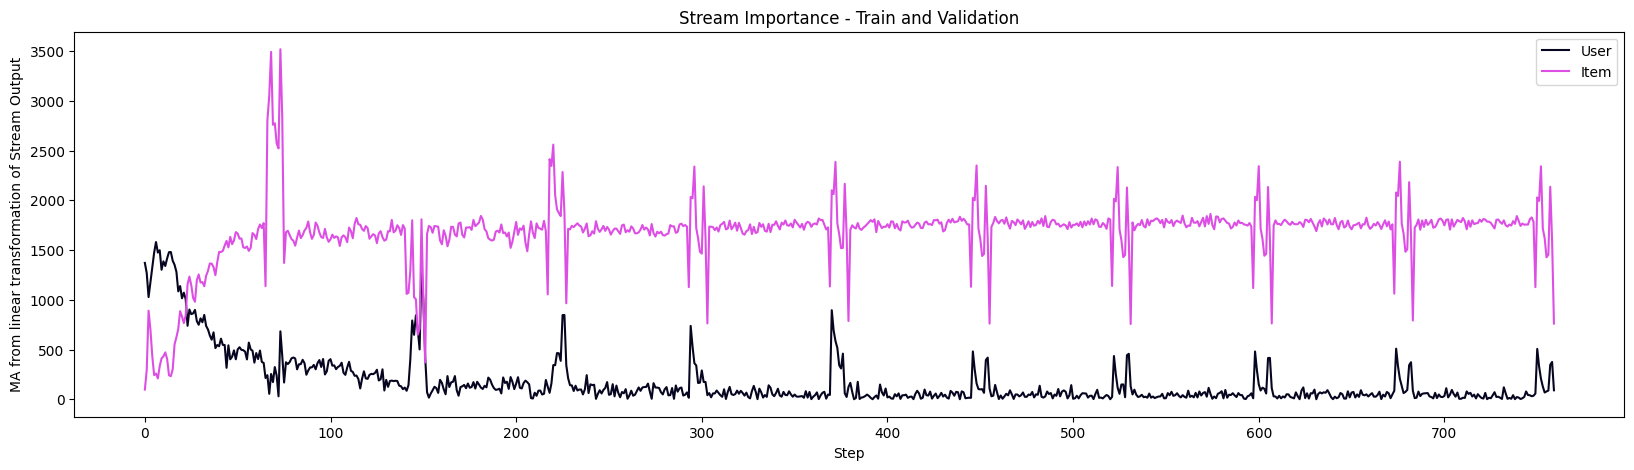

In [6]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(x[:770], label='User', color='#070620')
plt.plot(y[:770], label='Item', color='#dd4fe4')
plt.legend()
plt.title('Stream Importance - Train and Validation')
plt.xlabel('Step')
plt.ylabel('MA from linear transformation of Stream Output')
plt.show()

##### Plot Test data

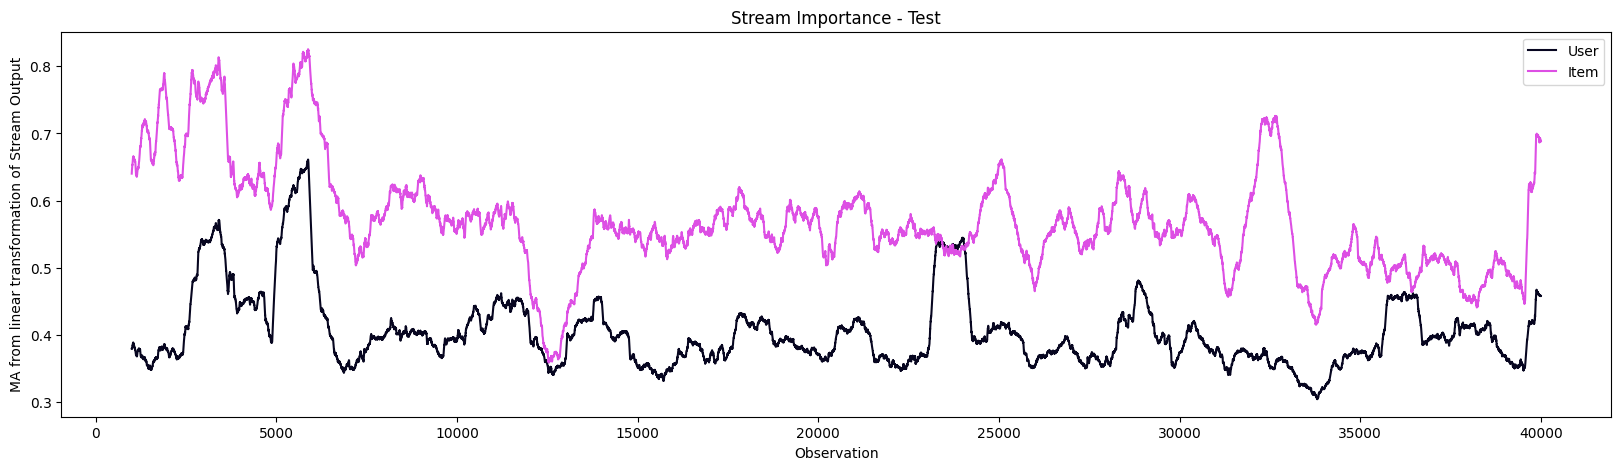

In [51]:
plt.plot(pd.Series(x[770:40000]).rolling(1000).mean().tolist(), label='User', color='#070620')
plt.plot(pd.Series(y[770:40000]).rolling(1000).mean().tolist(), label='Item', color='#dd4fe4')
plt.legend()
plt.title('Stream Importance - Test')
plt.xlabel('Observation')
plt.ylabel('MA from linear transformation of Stream Output')
plt.show()